# Исследование поведения пользователей мобильного приложения

Заказчик - компания-стартап, продающая продукты питания. Команда дизайна хочет поменять внести изменения в пользовательский интерфейс мобильного приложения (смена шрифтов), ну руководство сомневается в положительном отклике пользователей.

**Цель исследования** - проанализировать данные A/A/B-эксперимента по внедрению новых шрифтов и сформулировать общие выводы/рекомендации.

**Ход исследования**

Данные для исследования представлены в файле `logs_exp.csv` - это таблица с логами пользователей. Необходимо провести обзор и предобработку данных - обработать возможные дубликаты и пропуски, при необходимости поменять тип данных и создать дополнительные столбцы. Затем будет проведён общий исследовательский анализ, главная цель которого - установление актуального периода исследования. По результатам будет сформирована и проанализирована воронка событий, а финальным этапом станет непосредственный анализ результатов эксперемента. По итогам исследования будут сформированы общие выводы и рекомендации.

Таким образом, исследование будет разделено на следующие этапы:

1. [**Обзор и предобработка данных**](#1)
3. [**Исследовательский анализ данных**](#2)
4. [**Анализ воронки событий**](#3)
5. [**Изучение результатов эксперемента**](#4)
6. [**Общий вывод**](#5)

<a id='1'></a>

## Обзор и предобработка данных

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

- `EventName` — название события; 		
- `DeviceIDHash` — уникальный идентификатор пользователя; 		
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
# импортируем библиотеки для работы с данными

import os
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objects as go

import plotly.express as px

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
sns.set_style('darkgrid')
sns.set(font_scale = 2)
plt.rcParams.update({'axes.labelsize': 15,'axes.titlesize': 25})
os.chdir('C:\\Users\\dmitr\\GitHub\\Practicum-Data-Analysis\\datasets')

In [2]:
import plotly.io as pio

pio.renderers.default = "svg"

In [3]:
# загружаем данные о заказах, сразу переименуем колонки

data = (
    pd
    .read_csv('logs_exp.csv', sep='\t')
    .rename(columns={'EventName':'event_type', 
                     'DeviceIDHash':'user_id', 
                     'EventTimestamp':'event_time', 
                     'ExpId':'test_group'})
)

# выводим таблицу и основную информацию по ней

data.info()
data.sample(10, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_type  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   test_group  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,event_type,user_id,event_time,test_group
120873,MainScreenAppear,9096061512161785646,1564917596,248
4103,OffersScreenAppear,1074933668878523996,1564631437,247
92724,OffersScreenAppear,8115340604306569112,1564838447,246
128891,CartScreenAppear,3163109716415429772,1564930563,246
186942,OffersScreenAppear,2405626918155135838,1565082344,247
100277,PaymentScreenSuccessful,261817378841141406,1564850327,248
43950,CartScreenAppear,8407622027339743528,1564725755,248
28710,PaymentScreenSuccessful,6932456362538839381,1564676322,247
4837,OffersScreenAppear,6540987493924323038,1564634815,246
135461,PaymentScreenSuccessful,3198863056321683492,1564940990,248


Сразу бросается в глаза числовой формат даты в `event_time`, который должен содержать время события. Похоже на формат `unix`, попробуем преобразовать:

In [4]:
# перед предобработкой на всякий случай сохраним сырой датасет

original = data.copy()

# преобразуем дату

data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

В ходе исследования возможно понадобится провести когортный анализ - для этого выделим отдельный столбец с датой события. Затем посмотрим разброс дат в данных:

In [5]:
# выделяем дату в отдельный столбец

data['event_date'] = (
    data['event_time']
    .dt.date
    .astype('datetime64[ns]')
)

# выведем описательную статистику

data['event_date'].describe(datetime_is_numeric=True)

count                           244126
mean     2019-08-03 21:33:08.209367296
min                2019-07-25 00:00:00
25%                2019-08-02 00:00:00
50%                2019-08-04 00:00:00
75%                2019-08-06 00:00:00
max                2019-08-07 00:00:00
Name: event_date, dtype: object

- Данные содержат события с 25.07.2019 по 07.08.2019 - ровно две недели.

Теперь рассмотрим остальные столбцы по отдельности:

In [6]:
# столбец с событиями 
# выведем описательную статистику и посчитаем уникальные события

data['event_type'].describe()
data['event_type'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_type, dtype: int64

- Всего в данных содержится пять уникальных пользовательских событий:

    - `MainScreenAppear` - отображение главного экрана
    - `OffersScreenAppear` - отображение экрана с предложением
    - `CartScreenAppear` - отображение экрана с корзиной товаров
    - `PaymentScreenSuccessful` - экран с сообщением об успешной оплате
    - `Tutorial` - обучение

Заменим значения более понятные:

In [7]:
# создаём словарь значений

correct_values = dict(
    MainScreenAppear = 'главный экран',
    OffersScreenAppear = 'экран с предложением',
    CartScreenAppear = 'экран с корзиной товаров',
    PaymentScreenSuccessful = 'сообщение об успешной оплате',
    Tutorial = 'обучение')

# производим замену

data['event_type'] = (
    data['event_type']
    .replace(correct_values)
)

Для экономии памяти преобразуем данные в категорию и перейдём к следующему столбцу:

In [8]:
data['event_type'] = data['event_type'].astype('category')

# столбец с уникальным идентификатором пользователя
# посчитаем количество уникальных значений столбца пользователей
# заодно используем предыдущий столбец для подсчёта среднего количества событий и покупок

unique_users = data['user_id'].unique().size
mean_events = round(data['event_type'].count()/unique_users)
mean_purhases = round(
    data[
        data['event_type'] == 'сообщение об успешной оплате'
    ]['event_type']
    .count()/unique_users)

print(f'Таблица содержит данные {unique_users} уникальных пользователей, ' 
      f'на каждого в среднем приходится {mean_events} события, в том числе {mean_purhases} покупок.')

Таблица содержит данные 7551 уникальных пользователей, на каждого в среднем приходится 32 события, в том числе 5 покупок.


Переходим дальше:

In [9]:
# столбец с номером группы в A/A/B тестировании
# согласно документации в данных должно быть только три группы

data['test_group'].value_counts()

248    85747
246    80304
247    78075
Name: test_group, dtype: int64

Столбец содержит три уникальных значения, как и должно быть. Для удобства переименуем значения и преобразуем тип данных в категорию:

In [10]:
# контрольные группы назовём 'A_1' и 'A_2'
# а эксперементальную -'B'

data['test_group'] = (
    data['test_group']
    .replace({246:'A_1', 247:'A_2', 248:'B'})
    .astype('category')
)
data['test_group'].value_counts()

B      85747
A_1    80304
A_2    78075
Name: test_group, dtype: int64

На всякий случай проверим, что никто из пользователей не попал в две эксперементальные группы одновременно:

In [11]:
# напишем функцию для проверки совпадений 
# идентификаторов пользователей разных групп

def inter_check(group_1, group_2):
    
    inter = np.intersect1d(
        data[data['test_group'] == group_1]['user_id'].unique(),
        data[data['test_group'] == group_2]['user_id'].unique()
    )
    return inter.size

inter = sum(
    [inter_check('A_1', 'A_2'),
     inter_check('A_1', 'B'),
     inter_check('A_2', 'B')]
)
            
print(f' Уникальных пользователей, попавших в две группы одновременно - {inter}')

 Уникальных пользователей, попавших в две группы одновременно - 0


Теперь проверим данные на явные дубликаты:

In [12]:
dup_sum = data.duplicated().sum()
dup_share = round(dup_sum/len(data), 4)

print(f'Данные содержат {dup_sum} задублированных строк, их доля составляет {dup_share}.')

Данные содержат 413 задублированных строк, их доля составляет 0.0017.


Так как доля дубликатов составляет менее 1%, их можно оставить как есть без последствий для исследования.

### Итоги
В ходе предобработки были рассмотрены данные каждого столбца, была произведена проверка на дубликаты и частично изменены типы данных.

Сравним обработанный и сырой датасеты:

In [13]:
# разница в объёме используемой памяти

memory_diff = (
    round((original.memory_usage().sum()
           /data.memory_usage().sum()-1)*100, 2)
)

print(f'В ходе предобработки данных удалось сократить использование памяти на {memory_diff}%.')
print()

# выводим обработанную таблицу

data.info()
data.sample(10, random_state=1)

В ходе предобработки данных удалось сократить использование памяти на 23.07%.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  244126 non-null  category      
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   test_group  244126 non-null  category      
 4   event_date  244126 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(1)
memory usage: 6.1 MB


,event_type,user_id,event_time,test_group,event_date
120873,главный экран,9096061512161785646,2019-08-04 11:19:56,B,2019-08-04
4103,экран с предложением,1074933668878523996,2019-08-01 03:50:37,A_2,2019-08-01
92724,экран с предложением,8115340604306569112,2019-08-03 13:20:47,A_1,2019-08-03
128891,экран с корзиной товаров,3163109716415429772,2019-08-04 14:56:03,A_1,2019-08-04
186942,экран с предложением,2405626918155135838,2019-08-06 09:05:44,A_2,2019-08-06
100277,сообщение об успешной оплате,261817378841141406,2019-08-03 16:38:47,B,2019-08-03
43950,экран с корзиной товаров,8407622027339743528,2019-08-02 06:02:35,B,2019-08-02
28710,сообщение об успешной оплате,6932456362538839381,2019-08-01 16:18:42,A_2,2019-08-01
4837,экран с предложением,6540987493924323038,2019-08-01 04:46:55,A_1,2019-08-01
135461,сообщение об успешной оплате,3198863056321683492,2019-08-04 17:49:50,B,2019-08-04


Изменение типа данных позволило значительно сократить объёмы используемой памяти, даже несмотря на создание отдельного столбца с датами.
____
**Что было отмечено при работе с данными**:

- Данные содержат события с 25.07.2019 по 07.08.2019 - ровно две недели.


- В данных содержится пять уникальных пользовательских событий:

    - `MainScreenAppear` - отображение главного экрана
    - `OffersScreenAppear` - отображение экрана с предложением
    - `CartScreenAppear` - отображение экрана с корзиной товаров
    - `PaymentScreenSuccessful` - экран с сообщением об успешной оплате
    - `Tutorial` - обучение
    
    
- Таблица содержит данные 7551 уникальных пользователей, на каждого в среднем приходится 32 события.

<a id='2'></a>

## Исследовательский анализ данных

Основная цель этого этапа - установление актуального периода исследования. Необходимо изучить датасет на предмет наличия полных данных за весь период, во избежание влияние аномалий на результаты исследования.

Для начала посчитаем количество уникальных пользователей за каждый день (метрика `DAU`) и количество событий:

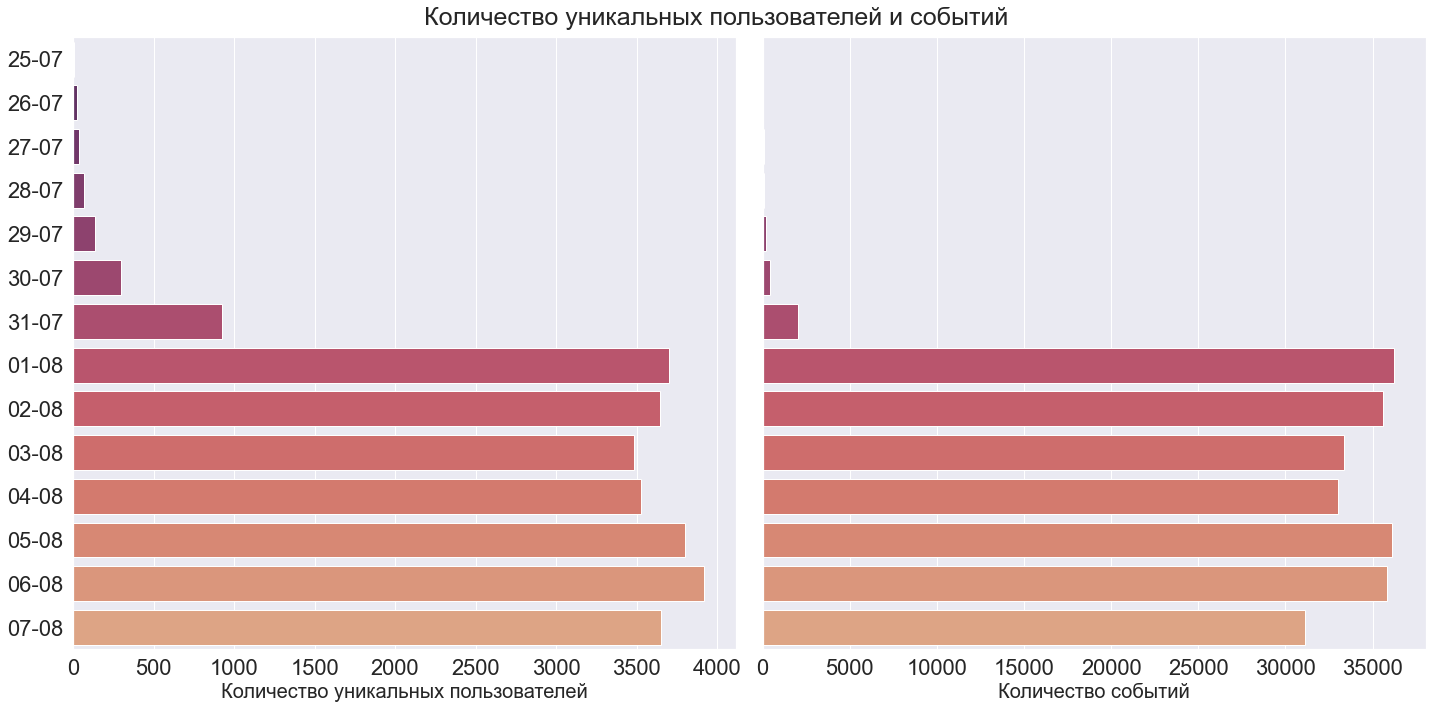

In [14]:
# сделаем копию датасета для eda

eda = data.copy()

# считаем dau и количество событий

dau_events = (
    eda
    .pivot_table(index='event_date', 
                 values=('user_id', 'event_type'),
                 aggfunc={'user_id':'nunique', 'event_type':'count'}
                )
    .reset_index()
    .rename(columns={'event_date':'date',
                     'event_type':'events',
                     'user_id':'unique_users'
                    })
)

# визуализируем результат

dates = (
    dau_events['date']
    .dt.strftime('%d-%m')
)

def barp(par, ax):
    
    sns.barplot(data=dau_events,
                x=par, y='date', 
                ax=ax, palette='flare_r')

    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20, 10), sharey=True)

barp('unique_users', ax1)
barp('events', ax2)


ax1.set_yticklabels(dates)
ax1.set_ylabel(None)
ax1.set_xlabel('Количество уникальных пользователей', fontsize=20)

ax2.set_ylabel(None)
ax2.set_xlabel('Количество событий', fontsize=20)


plt.suptitle('Количество уникальных пользователей и событий', fontsize=25)
plt.tight_layout()

plt.show()

До 31.07 в приложении как-будто практически ничего не происходит. Попробуем визулизировать количество событий по точному времени, чтобы определить момент начала полноценной активности пользователей:

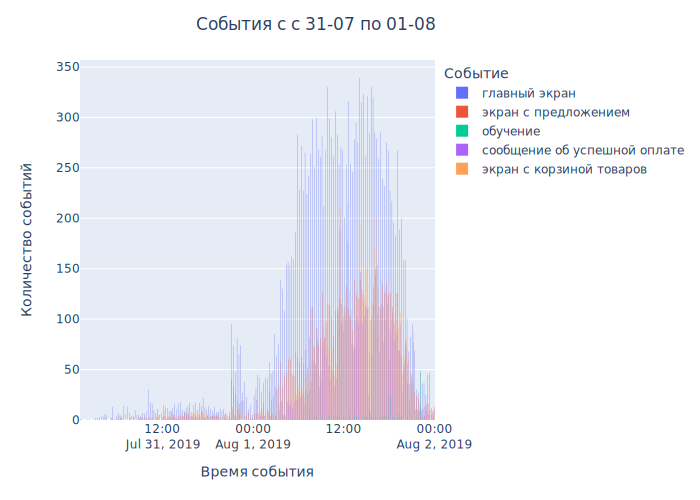

In [15]:
# возьмём данные с 31-07 по 01-08
# и визуализируем количество событий

events = eda.query('20190730 < event_date < 20190802')

labels = dict(
    event_time = 'Время события',
    event_type = 'Событие',
    count = 'Количество событий'
)

fig = (
    px.histogram(events,x='event_time', 
                 color='event_type', 
                 barmode='group',
                 labels=labels)
)

fig.update_yaxes(title='Количество событий')
fig.update_layout(title = 'События с с 31-07 по 01-08', title_x= .28)

fig.show()

На графике отчётливо виден рост активности 31-07, начиная примерно с 21:00 - это и станет точкой начала актуального периода исследования:

In [16]:
# фильтруем данные

eda = eda.query('20190731210000 <= event_time')

Теперь заново расчитаем основные параметры - количество уникальных событий и пользователей, среднее количество событий, распределение пользователей по группа эксперемента:

In [17]:
eda_unique_users = eda['user_id'].unique().size
eda_mean_events = round(eda['event_type'].count()/unique_users)
eda_mean_purhases = round(
    eda[
        eda['event_type'] == 'сообщение об успешной оплате'
    ]['event_type']
    .count()/unique_users)

print(f'Обработанная таблица содержит данные {eda_unique_users} уникальных пользователей, ' 
      f'на каждого в среднем приходится {eda_mean_events} события, \n' 
      f'в том числе {eda_mean_purhases} покупок. Было удалено {round(len(eda)/len(data), 2)}% оригинального датасета.\n'
      f'Разница в количестве уникальных пользователей составляет {unique_users-eda_unique_users}.'
     )

Обработанная таблица содержит данные 7538 уникальных пользователей, на каждого в среднем приходится 32 события, 
в том числе 5 покупок. Было удалено 0.99% оригинального датасета.
Разница в количестве уникальных пользователей составляет 13.


Сократив исследуемый период вдвое, мы потеряли лишь 1% данных. 13 уникальных пользователей было потеряно, но среднее число событий и покупок осталось без изменений. 
Последний шаг - проверим соотношение распределения пользователей по эксперементальным группам:

In [18]:
# посчитаем уникальных пользователей оригинального датафрейма
# и добавим данные обработанной таблицы

test_groups = (
    data['test_group']
    .value_counts()
    .reset_index()
    .rename(columns={
        'index':'group',
        'test_group':'original_users'})
    .merge(eda['test_group']
           .value_counts()
           .reset_index(), 
           right_on='index',
           left_on='group')
    .drop('index', axis=1)
    .rename(columns={'test_group':'actual_users'})
    .set_index('group')
)

# посчитаем оригинальное соотношение

test_groups['original_ratio'] = round(
    test_groups['original_users']/
    test_groups['original_users'].sum(), 2
)

# соотношение обработанной таблицы

test_groups['actual_ratio'] = round(
    test_groups['actual_users']/
    test_groups['actual_users'].sum(), 2
)

test_groups

,original_users,actual_users,original_ratio,actual_ratio
group,,,,
B,85747,85039,0.35,0.35
A_1,80304,79679,0.33,0.33
A_2,78075,77418,0.32,0.32


Соотношение распределения пользователей по эксперементальным группам также не изменилось, что лишний раз подтверждает корректность установленного актуального периода исследования.

In [19]:
# обновляем датафрейм

data = eda

# смотрим минимальное и максимальное время в обновлённых данных

display(data['event_time'].min())
data['event_time'].max()

Timestamp('2019-07-31 21:00:57')

Timestamp('2019-08-07 21:15:17')

____
Таким образом, актуальный период исследования - с **2019-07-31 21:00:00** по **2019-08-07 21:15:00**.

<a id='3'></a>

## Анализ воронки событий
Перейдём к анализу самих событий - посчитаем количество событий и пользователей, которые их совершают, а затем построим воронку:

In [20]:
# группируем данные

events = (
    data
    .pivot_table(index=('event_date','event_type'), 
                 values='user_id',
                 aggfunc=('count','nunique')
                )
    .reset_index()
    .rename(columns=dict(
        count = 'events',
        nunique='unique_users'))
    .sort_values('events', ascending=False)
)

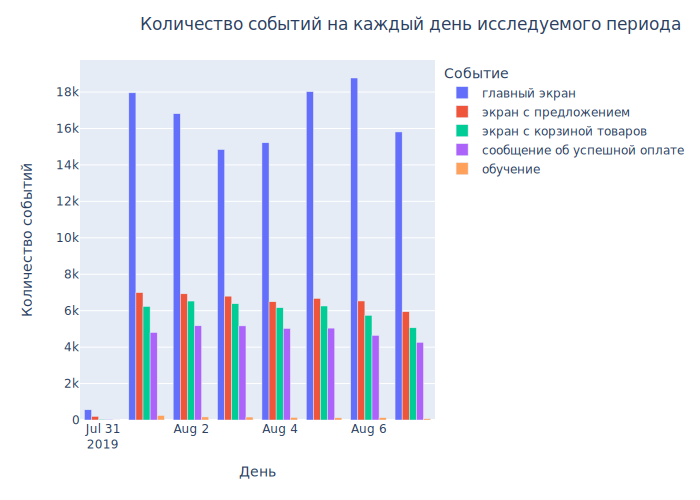

In [21]:
# визуализируем количество событий по типам

labels = dict(
    event_date = 'День',
    event_type = 'Событие',
    events = 'Количество событий'
)

fig = px.bar(
    events, x='event_date', 
    y='events', color='event_type', 
    barmode='group', labels=labels
)

fig.update_layout(title = 'Количество событий на каждый день исследуемого периода', title_x= .2)
fig.show()

- Каждый день событие `обучение` происходит значительно реже остальных - видимо это не обязательный модуль приложения, который пользователи могут включать по желанию. В таком случае включать его в воронку событий будет нецелесообразно. Количество других событий же может говорить об их прямой последовательности, несмотря на то, `экран с предложением` скорее всего является необязательным для совершения покупки.

Построим воронку событий по пользователям:

In [22]:
# сгруппируем данные, уберём экран обучения из воронки

events = (
    data
    .groupby('event_type')
    .agg(dict(user_id='nunique'))
    .drop(labels='обучение', axis=0)
    .reset_index()
    .append(
        dict(event_type='всего пользователей',
             user_id=eda_unique_users), ignore_index=True)
    .sort_values('user_id', ascending=False)
    .reset_index(drop=True)
    .rename(columns=dict(
        count = 'events',
        user_id='unique_users'))
)


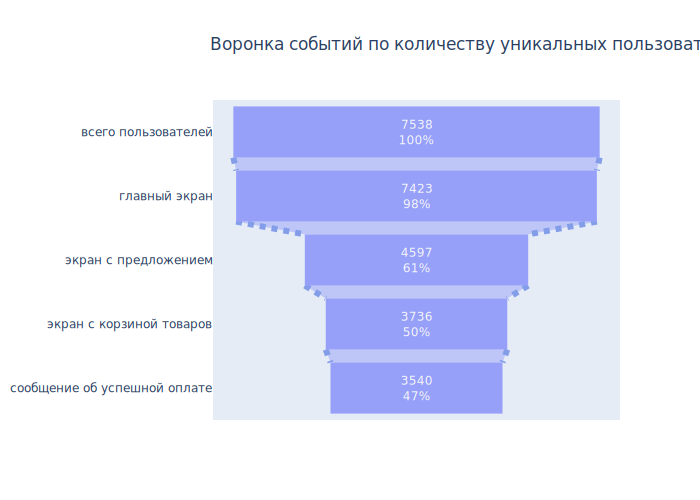

In [23]:
# строим воронку

fig = go.Figure(go.Funnel(
    y = events['event_type'],
    x = events['unique_users'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.6,
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 6}})
    )


fig.update_layout(title = 'Воронка событий по количеству уникальных пользователей', title_x= .3)
fig.show()

- В целом у магазина очень хорошая конверсия - около 47% всех пользователейувиди в итоге совершают покупку. Самая низкая конверсия в шаг наблюдается у экрана с предложением - она составляет около 60%, тогда как конверсия остальных шагов составляет более 80%.

- Так как даже `Главный экран` видят не все пользователи (98%), последовательность событий для отдельных пользователей может отличаться.

<a id='4'></a>

## Изучение результатов эксперемента
Для начала повторим воронку событий из предыдущего шага, но уже в разрезе групп эксперемента:

In [24]:
# посчитаем общий размер групп и количество событий

def uniq_gr(group):
    unq = (
        data[data['test_group'] == group]['user_id']
        .unique()
        .size
    )
    return pd.Series(
        ['всего пользователей', group, unq],
        index=['event_type', 'test_group', 'unique_users']
    )

groups = [uniq_gr('A_1'), uniq_gr('A_2'), uniq_gr('B')]

# группируем данные, добавим итоги в таблицу

events_grouped = (
    data
    .pivot_table(index=('event_type','test_group'), 
                 values='user_id',
                 aggfunc='nunique',
                )
    .rename(columns=dict(
        user_id='unique_users'))
    .reset_index()
    .append(groups, ignore_index=True)
    .sort_values('unique_users', ascending=False)
    .reset_index(drop=True)

)

<a id='funnel'></a>

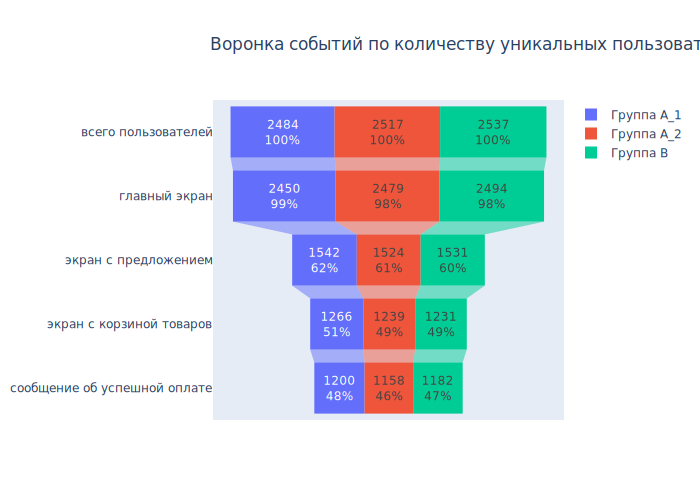

In [25]:
# строим воронку

funn_df = events_grouped.query('event_type != "обучение"')

def funn(group):

    fig.add_trace(go.Funnel(
        name = 'Группа ' + group,
        y = funn_df[funn_df['test_group'] == group]['event_type'],
        x = funn_df[funn_df['test_group'] == group]['unique_users'],
        textinfo = "value+percent initial"))

fig = go.Figure()
   
for groups in ['A_1', 'A_2', 'B']:
    funn(groups) 

fig.update_layout(title = 'Воронка событий по количеству уникальных пользователей', title_x= .3)
fig.show()

В целом доля конверсии в шаг не отличается от общей воронки. А вот различие показателей контрольных групп на некоторых шагах составляет более 1%, что может быть плохим знаком. Потому при анализе результатов эксперементальной группы необходимо в том числе расчитать статистическую значимость различий конверсий контрольных групп.

Общие гипотезы для всех групп:

1. **Нулевая гипотеза** - конверсии события от общего числа пользователей имеет статистически значимой разницы
2. **Альтернативная гипотеза** - есть основания полагать, что конверсии отличаются.

Так как данные для расчёта статистической значимости являются долями, оптимальным инструментом станет <a href="https://en.wikipedia.org/wiki/Z-test">**Z-критерий Фишера**</a>:

In [26]:
# напишем функцию для проверки гипотез

def stat_check(successes_1, successes_2, trials_1, trials_2, alpha=.05):
    
    p1 = successes_1/trials_1
    p2 = successes_2/trials_2
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)

    difference = p1 - p2
    z_value = (
        difference / mth.sqrt(
            p_combined * (1 - p_combined) * (
                1/trials_1 + 1/trials_2))
    )

    distr = st.norm(0, 1) 
    alpha = alpha

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу, есть основания полагать, что данные отличаются")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы ")  

In [27]:
# создадим необходимые для проверки переменные

# количество пользователей каждой группы

total = (
    events_grouped
    .query('event_type == "всего пользователей"')
    .sort_values('test_group')
    .reset_index(drop=True)
)

a_1_total = total.loc[0]['unique_users']
a_2_total = total.loc[1]['unique_users']
b_total = total.loc[2]['unique_users']

# список событий

events_list = (
    events_grouped['event_type']
    .unique()
    .tolist()
)
del events_list[0]

In [28]:
# функция для получения значения группы для события

def get_val(group):
    val = int(
        events_grouped.query(
            'event_type == @event and test_group == @group')
        ['unique_users'])
    return val

# запускаем цикл проверки всех событий контрольных групп

run_count = 0 # счётчик количества проверок

for event in events_list:
    
    a_1 = get_val('A_1')
    a_2 = get_val('A_2')
    
    print(f'Проверка групп A_1 и A_2 в событии "{event}"')
    print()
    stat_check(a_1, a_2, a_1_total, a_2_total)
    run_count += 1
    print()

Проверка групп A_1 и A_2 в событии "главный экран"

p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и A_2 в событии "экран с предложением"

p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и A_2 в событии "экран с корзиной товаров"

p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и A_2 в событии "сообщение об успешной оплате"

p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и A_2 в событии "обучение"

p-значение:  0.9182790262812368
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 



Несмотря на разницу в абсолютных значений, которую показала [воронка событий](#funnel) - статистическая значимость разницы конверсий контрольных групп не наблюдается.

Теперь сравним результаты эксперементальной группы по очереди с каждой из контрольных:

In [29]:
# запускаем цикл проверки событий для эксперементальной и первой контрольной группы

print('Сравниваем первую контрольную группу с эксперементальной')
print('\n')

for event in events_list:
    
    a_1 = get_val('A_1')
    b = get_val('B')
    
    print(f'Проверка групп A_1 и B в событии "{event}"')
    print()
    stat_check(a_1, b, a_1_total, b_total)
    run_count += 1

    print()

print('\n')
print('Сравниваем вторую контрольную группу с эксперементальной')
print('\n')
    
# запускаем цикл проверки событий для эксперементальной и второй контрольной группы

for event in events_list:
    
    a_2 = get_val('A_2')
    b = get_val('B')
    
    print(f'Проверка групп A_2 и B в событии "{event}"')
    print()
    stat_check(a_2, b, a_2_total, b_total)
    run_count += 1

    print()

Сравниваем первую контрольную группу с эксперементальной


Проверка групп A_1 и B в событии "главный экран"

p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и B в событии "экран с предложением"

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и B в событии "экран с корзиной товаров"

p-значение:  0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и B в событии "сообщение об успешной оплате"

p-значение:  0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и B в событии "обучение"

p-значение:  0.8964489622133207
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 


Ни одна из проверок не показывает статистически значимой разницы конверсии в событие.

Попробуем объединить контрольные группы и провести ещё одну проверку:

In [30]:
# запускаем цикл проверки событий для эксперементальной и обеих контрольных групп

print('Сравниваем обе контрольные группы с эксперементальной')
print('\n')

for event in events_list:
    
    a = get_val('A_1') + get_val('A_2')
    b = get_val('B')
    
    print(f'Проверка групп A_1 и B в событии "{event}"')
    print()
    stat_check(a, b, a_1_total + a_2_total, b_total)
    run_count += 1

    print()


Сравниваем обе контрольные группы с эксперементальной


Проверка групп A_1 и B в событии "главный экран"

p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и B в событии "экран с предложением"

p-значение:  0.418998284007599
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и B в событии "экран с корзиной товаров"

p-значение:  0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и B в событии "сообщение об успешной оплате"

p-значение:  0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 

Проверка групп A_1 и B в событии "обучение"

p-значение:  0.8333049080125807
Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы 



На данный момент результаты всех проверок не указывают на наличии статистической значимости групп в конверсии пользовательских событий.

<a id='5'></a>

## Общий вывод

____
**Рекомендации**

- Сделать экран с обучением обязательным для пользователей - возможно конверсия в каждый шаг воронки событий падает именно из-за того, что пользователи не до конца понимают функционал приложения.


- Принять меры для более тщательного отбора пользователей для формирования контрольных групп - несмотря на отсутствие статистически значимой разницы с поправкой на множественное сравнение, абсолютные значения конверсии групп в большинстве событий имеет разницу, превышающую 1%. Без коррекции порога значимости включение данных первой контрольной группы гарантирует наличие статистически значимых различий, что в данном контексте негативно характеризует её репрезентативность.


- Результаты анализа теста не показывают статистически значимых изменений метрик. Если цель эксперемента была в том, чтобы убедится, что новведения не ухудшат показетели - его можно считать успешным. Но если целью новведения было улучшение показателей - проведение подобного эксперемента, учитывая потенциальные трудовые и материальные затраты, было нецелесообразно. В таком случае необходима более тщательная работа по приоритезации гипотез для проверки A/B тестом.
____



Целью исследования являлось анализ данных A/A/B-эксперимента по внедрению новых шрифтов и формулирования рекомендаций.

Данные для исследования были представлены в файле `logs_exp.csv` - это таблица с логами пользователей. Необходимо было провести обзор и предобработку данных - обработать возможные дубликаты и пропуски, при необходимости поменять тип данных и создать дополнительные столбцы. Затем был проведён общий исследовательский анализ, главная цель которого - установление актуального периода исследования. По результатам былы сформирована и проанализирована воронка событий, а финальным этапом стал непосредственный анализ результатов эксперемента.

Таким образом, исследование было разделено на следующие этапы:

1. [**Обзор и предобработка данных**](#1)
3. [**Исследовательский анализ данных**](#2)
4. [**Анализ воронки событий**](#3)
5. [**Изучение результатов эксперемента**](#4)
6. [**Общий вывод**](#5)

В ходе предобработки были рассмотрены данные каждого столбца, была произведена проверка на дубликаты и частично изменены типы данных.

Изменение типа данных позволило значительно сократить объёмы используемой памяти, даже несмотря на создание отдельного столбца с датами.


**Что было отмечено при работе с данными**:

- Данные содержат события с 25.07.2019 по 07.08.2019 - ровно две недели.


- В данных содержится пять уникальных пользовательских событий:

    - `MainScreenAppear` - отображение главного экрана
    - `OffersScreenAppear` - отображение экрана с предложением
    - `CartScreenAppear` - отображение экрана с корзиной товаров
    - `PaymentScreenSuccessful` - экран с сообщением об успешной оплате
    - `Tutorial` - обучение
    
    
- Таблица содержит данные 7551 уникальных пользователей, на каждого в среднем приходится 32 события, в том числе 5 покупок.

Основная целью исследовательского анализа было установление актуального периода исследования. Необходимо было изучить датасет на предмет наличия полных данных за весь период, во избежание влияние аномалий на результаты исследования.

На графиках был отчётливо виден рост активности 31-07, начиная примерно с 21:00 - это и стало точкой начала актуального периода исследования.

Сократив исследуемый период вдвое, мы потеряли лишь 1% данных. 13 уникальных пользователей было потеряно, но среднее число событий осталось без изменений. 

Соотношение распределения пользователей по эксперементальным группам также не изменилось, что лишний раз подтверждает корректность установленного актуального периода исследования.

Таким образом, актуальный период исследования - с **2019-07-31 21:00:00** по **2019-08-07 21:15:00**.

Анализ количества событий и уникальных пользователей показал, что каждый день событие `обучение` происходит значительно реже остальных - видимо это не обязательный модуль приложения, который пользователи могут включать по желанию. В таком случае включать его в воронку событий было нецелесообразно. Количество других событий же может говорить об их прямой последовательности, несмотря на то, `экран с предложением` скорее всего является необязательным для совершения покупки.

Воронка событий продемонстрировала в целом очень хорошую конверсия - около 47% всех пользователей в итоге совершают покупку. Самая низкая конверсия в шаг наблюдается у экрана с предложением - она составляет около 60%, тогда как конверсия остальных шагов составляет более 80%. Но так как даже `Главный экран` видят не все пользователи (98%), последовательность событий для отдельных пользователей может отличаться.

В варианте воронки событий в разрезе групп эксперимента в целом доля конверсии в шаг не отличается от общей воронки. А вот различие показателей контрольных групп на некоторых шагах составляет более 1%, что может быть плохим знаком. Потому при анализе результатов эксперементальной группы необходимо в том числе расчитать статистическую значимость различий конверсий контрольных групп.

Общие гипотезы для всех групп:

1. **Нулевая гипотеза** - конверсии события от общего числа пользователей имеет статистически значимой разницы
2. **Альтернативная гипотеза** - есть основания полагать, что конверсии отличаются.

На данный момент результаты всех проверок не указывают на наличии статистической значимости групп в конверсии пользовательских событий.

При сравнении результатов контрольных и эксперементальных групп статистической значимости результатов также не было выявлено.

<a id='5'></a>